# Proyecto 1
<h3>Natalia Ortega (sección 4), David Leon (sección 3) & Juan Camilo Mercado (sección 4)</h3>

## 0. Carga de librerías y datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn as sklearn
import numpy as np
import nltk
import random
import statistics
import string
import unicodedata

from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.probability import *
from nltk.tokenize import word_tokenize

from scipy import stats as st

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

from gensim.models import Word2Vec

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from sklearn import tree


C:\Users\CAMILO\AppData\Local\Temp\ipykernel_20904\539616550.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


se descargan los módulos específicos de la librería nltk para poder procesar le texto de la mejor forma posible:

In [2]:
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('wordnet');

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('./data/tipo2_entrenamiento_estudiantes.csv', sep=',', encoding = 'utf-8')

## 1. Entendimiento y preparación de datos

### Entendimiento

Con los datos de los actores de turismo leyendo el conjunto de datos correspondiente de reseñas de sitios turísticos, se procede a entender la estructura de los comentarios que estos nos presentan.

In [4]:
print(f">> Se puede observar que el df de entrenamiento contiene {df.shape[0]} reseñas")

>> Se puede observar que el df de entrenamiento contiene 7875 reseñas


Se observan que solo existen 2 columnas, una con la s¿reseña y otra con la calificación corrrespondiente, donde se identifica que no hay datos faltantes ni atípicos respecto al tipo de dato, pues la columna numérica peranece numérica.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [6]:
print(">> El df se ve de la siguiente forma:")
df.head()

>> El df se ve de la siguiente forma:


,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3


Cada una de estas reseñas contiene una calificación de acuerdo al sentimiento que tuvo el turista al visitarlo, por lo que es importante ver las tendencias de calificaciones, y las tendencias de las reseñas.

Se observa que las reseñas varían en cantidad de palabras, donde hay palabras que se repiten y generan una moda, los cuales suelen ser palabras que no aportan valor al análisis (no son sustantivos, verbos o adjetivos). Se observa el uso de mayúsculas y minúsuculas para diferenciar entre diferentes tipos de palabras, per en este contexto no aporta al análisis.

In [7]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Palabras únicas'] = [len(set(x)) for x in textos['Review']]
textos['Max. de palabra'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min. de palabra'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Moda'] = [statistics.mode(i.split(' ')) for i in textos['Review']]

textos

,Review,Class,Conteo,Palabras únicas,Max. de palabra,Min. de palabra,Moda
0,Muy buena atención y aclaración de dudas por p...,5,252,28,20,0,
1,Buen hotel si están obligados a estar cerca de...,3,297,34,13,1,de
2,"Es un lugar muy lindo para fotografías, visite...",5,104,26,12,1,Es
3,Abusados con la factura de alimentos siempre s...,3,422,28,14,1,y
4,Tuvimos un par de personas en el grupo que rea...,3,419,35,14,1,el
...,...,...,...,...,...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4,113,24,11,2,el
7871,"Fue una escapada de un día desde el complejo, ...",4,261,31,12,2,de
7872,La Plaza de la Revolución es un lugar emblemát...,3,777,43,14,1,de
7873,Es la segunda ocasión que me quedo en los cuar...,1,651,38,12,0,que


igualmente, se busca observar que las clases sean valores válidos y definidos (números enteros del 1 al 5). Además se busca observar su frecuencia para observar la cantidad de reseñas que tenemos como muestra de cada una de las clases correspondientes.

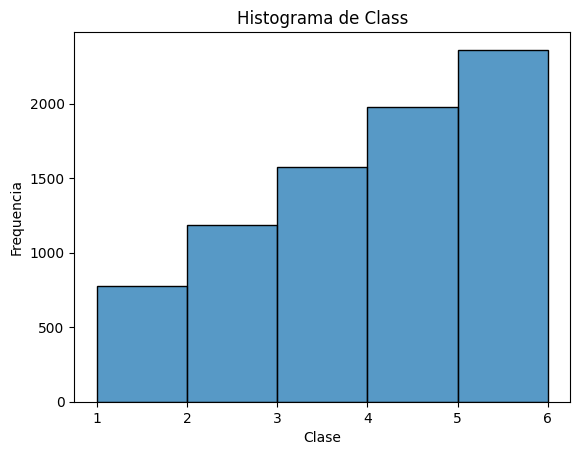

In [8]:
sns.histplot(data=textos, x='Class', bins=range(1, 7), kde=False)
plt.xlabel('Clase')
plt.ylabel('Frequencia')
plt.title('Histograma de Class')
plt.xticks(range(1, 7))
plt.show()

Se observa que hay mayor número de comentarios de clase 5, y va disminuyendo la cantidad con su categoría, por lo que se sabe que la mayor confiabilidad del entrenamiento se dará con la clase 5, así sucesivamente hasta la clase 1 que tendrá la menor confiabilidad al contar con la menor cantidad de datos para realizar el análisis.

Ahora bien, para darles significado, se muestran ejemplos de comentarios por clase para definir el significado de cada una.

In [9]:
pd.set_option('display.max_colwidth', None)

clases_muestra = df['Class'].unique()
comentarios_muestra = []
for clase in clases_muestra:
    comentario = df[df['Class'] == clase]['Review'].iloc[0]
    comentarios_muestra.append(comentario)
tabla_muestra = pd.DataFrame({'Clase': clases_muestra, 'Comentario': comentarios_muestra})
tabla_muestra.sort_values('Clase', inplace=True)

tabla_muestra


,Clase,Comentario
4,1,"Se equivocaron en la central de reservas y al llegar al hotel me cobraron más para poder alojarme Una habitación con 3 recamaras y me pusieron solo un huésped 🤦🏽‍♂️ No tienen sentido común, acabe pagando por las otras 5. O sea me engañaron 😡"
3,2,"Acabo de volver de Cuba. La primera semana en Tryp Habana libre y no puedo recomendar que a nadie. La primera imagen en el vestíbulo estaba bastante bien pero cuando salimos del ascensor en el piso, no pudimos evitar el olor a moho. Tras par de noche había una enorme fuga de agua en el baño y tuvimos que cambiar de habitación. La segunda habitación era tan fría que teníamos que llevar cordero grillada calcetines de lana y un suéter mientras duerme. Los recepcionistas eran todos antipático. El desayuno estaba bien, pero el piso 25 club nocturno terrible con banda ruidosa y mala. No bañados por ir a este hotel, que debe ser renovada completamente. Algo bueno? La vista ..."
1,3,"Buen hotel si están obligados a estar cerca del centro de convenciones, pero el restaurante necesita mejorar! Frío y café flojo - y - un montón de pan de personas que sirve unos uderstanding de bu lo que significa un servicio. En este barrio con tan pocas opciones - debería ser un hotel especial."
2,4,Un complejo enorme de fortificaciones frente al antiguo de La Habana. Visité en un día cuando el otro lado del castillo era trincadas con agua elevándose a 20 metros o más desde el mar.
0,5,"Muy buena atención y aclaración de dudas por parte de la señorita Verónica castillo, atenta y amable en cuestión laborable. Ideal para descansar muy buenas habitaciónes, limpieza, ordenadas. Buena comida de parte del restaurante,variedad en comidas"


Se observa que en este contexto los comentarios con clase 5 son aquellos de mayor positividad y gratitud, seguidos de la clase 4 que muestra positividad moderada pero notable. Los comentarios de clase 3 son aquellos que se muestran entre neutrales y buenos en su opinión,seguidos por la clase 2 que muestra tener comentarios negativos o levemente negativos, y finalmente, la clase 1 que muestra total desagrado con la experiencia.

Igualmente, se busca obtener las medidas de tendencia central para cada uno de los grupos de análisis de los comentarios, para observar el promedio de la longitud de los comentarios y las palabras únicas, qué tanto varían estas cantidades con la desviación estándar, cual es el máximo número de palabras únicas que existe y el mínimo. Esto será importante para observar cómo se puede comportar la lemantización futura de estas palabras.

In [10]:
textos.describe()

,Class,Conteo,Palabras únicas,Max. de palabra,Min. de palabra
count,7875.000000,7875.000000,7875.000000,7875.000000,7875.000000
mean,3.502603,408.404952,33.209016,13.226159,0.858540
std,1.320435,475.412353,7.968011,3.055498,0.515989
min,1.000000,9.000000,9.000000,4.000000,0.000000
25%,3.000000,197.000000,28.000000,11.000000,1.000000
50%,4.000000,269.000000,31.000000,13.000000,1.000000
75%,5.000000,488.500000,37.000000,14.000000,1.000000
max,5.000000,10419.000000,81.000000,76.000000,5.000000


Asimismo, se busca obsrvar un ejemplo de un comentario para ver cómo se distribuyen sus palabras y su frecuencia, igualmente para observar la influencia d caracteres como espacios, comas, tíldes u otros caracteres que puedan entorpecer el entendimiento del comentario para el algoritmo.

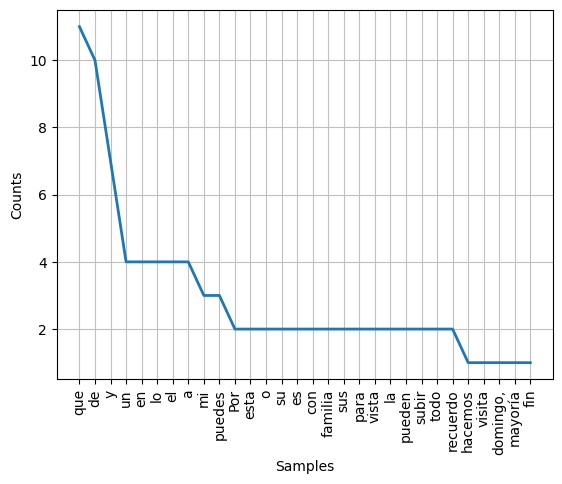

<Axes: xlabel='Samples', ylabel='Counts'>

In [11]:
fdist = FreqDist(df['Review'][random.randint(0, df.shape[0])].split(' '))
fdist.plot(30, cumulative = False)

Viendo que es evidente la influencia de los caracteres especiales en los comentarios se procede a hacer la limpieza de datos por lo que, como primer paso, se  hace la tokenización de los comentarios.

### Segmentación de palabras (tokenización)

La tokenización se realiza para convertir el texto en una forma que pueda ser procesada por algoritmos de ML. Al dividir el texto en tokens, se crea una representación estructurada que permite al algoritmo comprender y analizar el contenido del texto de manera más efectiva.

En este caso se hace tokenización basada en palabras. Este enfoque divide el texto en palabras individuales. Utiliza espacios en blanco y signos de puntuación como delimitadores para identificar las palabras.

In [12]:
def tokenize(data: pd.DataFrame):
    data['Words'] = data['Review'].apply(word_tokenize)
    return data

In [13]:
token_df = df.copy()
tokenize(token_df)
token_df.head()

,Review,Class,Words
0,"Muy buena atención y aclaración de dudas por parte de la señorita Verónica castillo, atenta y amable en cuestión laborable. Ideal para descansar muy buenas habitaciónes, limpieza, ordenadas. Buena comida de parte del restaurante,variedad en comidas",5,"[Muy, buena, atención, y, aclaración, de, dudas, por, parte, de, la, señorita, Verónica, castillo, ,, atenta, y, amable, en, cuestión, laborable, ., Ideal, para, descansar, muy, buenas, habitaciónes, ,, limpieza, ,, ordenadas, ., Buena, comida, de, parte, del, restaurante, ,, variedad, en, comidas]"
1,"Buen hotel si están obligados a estar cerca del centro de convenciones, pero el restaurante necesita mejorar! Frío y café flojo - y - un montón de pan de personas que sirve unos uderstanding de bu lo que significa un servicio. En este barrio con tan pocas opciones - debería ser un hotel especial.",3,"[Buen, hotel, si, están, obligados, a, estar, cerca, del, centro, de, convenciones, ,, pero, el, restaurante, necesita, mejorar, !, Frío, y, café, flojo, -, y, -, un, montón, de, pan, de, personas, que, sirve, unos, uderstanding, de, bu, lo, que, significa, un, servicio, ., En, este, barrio, con, tan, pocas, opciones, -, debería, ser, un, hotel, especial, .]"
2,"Es un lugar muy lindo para fotografías, visiten Selina, música en vivo, cerveza artesanal y buena comida",5,"[Es, un, lugar, muy, lindo, para, fotografías, ,, visiten, Selina, ,, música, en, vivo, ,, cerveza, artesanal, y, buena, comida]"
3,Abusados con la factura de alimentos siempre se echan la culpa unos a otros van y buscan el rfc que les proporcionaste por que independisan la base que ya tienen registrada en alimentos con la base del check in y ya pasaron 3 dias y aun nadade mi factura aunque hables de larga distancia y queden formalmente fe enviartela en un momento no es asi mañana otra vez voy a tener que hablar y para colmo ni el ticket me dieron.,3,"[Abusados, con, la, factura, de, alimentos, siempre, se, echan, la, culpa, unos, a, otros, van, y, buscan, el, rfc, que, les, proporcionaste, por, que, independisan, la, base, que, ya, tienen, registrada, en, alimentos, con, la, base, del, check, in, y, ya, pasaron, 3, dias, y, aun, nadade, mi, factura, aunque, hables, de, larga, distancia, y, queden, formalmente, fe, enviartela, en, un, momento, no, es, asi, mañana, otra, vez, voy, a, tener, que, hablar, y, para, colmo, ni, el, ticket, me, dieron, .]"
4,"Tuvimos un par de personas en el grupo que realmente queríamos comer cabrito, el resto de nosotros eran buenas con probarla. Servicio empezó realmente bien, hasta que llegamos a situar nuestros pedidos. Cuando le preguntamos acerca de cómo agregar o sustituir elementos el camarero casi...parecía molestarle y claro qué y cómo lo ve en el menú es la única opción. Aparte de eso, la comida y el ambiente donde genial!Más",3,"[Tuvimos, un, par, de, personas, en, el, grupo, que, realmente, queríamos, comer, cabrito, ,, el, resto, de, nosotros, eran, buenas, con, probarla, ., Servicio, empezó, realmente, bien, ,, hasta, que, llegamos, a, situar, nuestros, pedidos, ., Cuando, le, preguntamos, acerca, de, cómo, agregar, o, sustituir, elementos, el, camarero, casi, ..., parecía, molestarle, y, claro, qué, y, cómo, lo, ve, en, el, menú, es, la, única, opción, ., Aparte, de, eso, ,, la, comida, y, el, ambiente, donde, genial, !, Más]"


### Limpieza de datos (StopWords) y análisis lexicográfico

Como se observa, existen tokens que entorpecen el entendimiento de las palabras, como lo son los denominados stopwprds, los cuales son palabras comunes que se consideran irrelevantes para el análisis de texto debido a su alta frecuencia de aparición en un lenguaje determinado. Estas palabras, como "el", "la", "y", "a", "de", entre otras, no aportan información significativa para el análisis de texto y suelen ser eliminadas o ignoradas en tareas de procesamiento de lenguaje natural, por esto se hace el tratamiento respectivo para eliminarlas de los tokens con la clase TextProcessor, cyos objetos serán capaces que preprocesar los datos, pues, hará conversión en minúsculas, removerá caracteres especiales y signos de puntuación y finalmente hará la extracción de los lemas de las palabras para que lo importante sea su significado y no su forma gramatical.


In [14]:
class TextProcessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')
        self.punctuation = string.punctuation

    def to_lowercase(self, texto):
        return [word.lower() for word in texto]

    def remove_punctuation(self, texto):
        return [word for word in texto if word not in self.punctuation]

    def remove_triple_punctuation(self, texto):
        return [word for word in texto if word != '...']

    def remove_stopwords(self, texto):
        return [word for word in texto if word not in self.stop_words]

    def lemmatize(self, texto):
        return [self.lemmatizer.lemmatize(word) for word in texto]

    def stem(self, texto):
        return [self.stemmer.stem(word) for word in texto]

    def remove_non_ascii(self, texto):
        return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in texto]

    def preprocess(self, texto):
        texto = self.to_lowercase(texto)
        texto = self.remove_punctuation(texto)
        texto = self.remove_triple_punctuation(texto)
        texto = self.remove_stopwords(texto)
        texto = self.lemmatize(texto)
        texto = self.stem(texto)
        texto = self.remove_non_ascii(texto)
        return texto
    
def clean_process(data: pd.DataFrame):
    processor = TextProcessor()
    data['Stemmed words'] = [processor.preprocess(text) for text in data['Words']]
    return data

Ahora se hará la conversión respectiva con un objeto de la clase construida:

In [15]:
clean_process(token_df)
token_df.head()

,Review,Class,Words,Stemmed words
0,"Muy buena atención y aclaración de dudas por parte de la señorita Verónica castillo, atenta y amable en cuestión laborable. Ideal para descansar muy buenas habitaciónes, limpieza, ordenadas. Buena comida de parte del restaurante,variedad en comidas",5,"[Muy, buena, atención, y, aclaración, de, dudas, por, parte, de, la, señorita, Verónica, castillo, ,, atenta, y, amable, en, cuestión, laborable, ., Ideal, para, descansar, muy, buenas, habitaciónes, ,, limpieza, ,, ordenadas, ., Buena, comida, de, parte, del, restaurante, ,, variedad, en, comidas]","[buen, atencion, aclar, dud, part, senorit, veron, castill, atent, amabl, cuestion, labor, ideal, descans, buen, habitacion, limpiez, orden, buen, com, part, restaur, varied, com]"
1,"Buen hotel si están obligados a estar cerca del centro de convenciones, pero el restaurante necesita mejorar! Frío y café flojo - y - un montón de pan de personas que sirve unos uderstanding de bu lo que significa un servicio. En este barrio con tan pocas opciones - debería ser un hotel especial.",3,"[Buen, hotel, si, están, obligados, a, estar, cerca, del, centro, de, convenciones, ,, pero, el, restaurante, necesita, mejorar, !, Frío, y, café, flojo, -, y, -, un, montón, de, pan, de, personas, que, sirve, unos, uderstanding, de, bu, lo, que, significa, un, servicio, ., En, este, barrio, con, tan, pocas, opciones, -, debería, ser, un, hotel, especial, .]","[buen, hotel, si, oblig, cerc, centr, convencion, restaur, necesit, mejor, fri, caf, floj, monton, pan, person, sirv, uderstanding, bu, signif, servici, barri, tan, poc, opcion, deb, ser, hotel, especial]"
2,"Es un lugar muy lindo para fotografías, visiten Selina, música en vivo, cerveza artesanal y buena comida",5,"[Es, un, lugar, muy, lindo, para, fotografías, ,, visiten, Selina, ,, música, en, vivo, ,, cerveza, artesanal, y, buena, comida]","[lug, lind, fotograf, visit, selin, music, viv, cervez, artesanal, buen, com]"
3,Abusados con la factura de alimentos siempre se echan la culpa unos a otros van y buscan el rfc que les proporcionaste por que independisan la base que ya tienen registrada en alimentos con la base del check in y ya pasaron 3 dias y aun nadade mi factura aunque hables de larga distancia y queden formalmente fe enviartela en un momento no es asi mañana otra vez voy a tener que hablar y para colmo ni el ticket me dieron.,3,"[Abusados, con, la, factura, de, alimentos, siempre, se, echan, la, culpa, unos, a, otros, van, y, buscan, el, rfc, que, les, proporcionaste, por, que, independisan, la, base, que, ya, tienen, registrada, en, alimentos, con, la, base, del, check, in, y, ya, pasaron, 3, dias, y, aun, nadade, mi, factura, aunque, hables, de, larga, distancia, y, queden, formalmente, fe, enviartela, en, un, momento, no, es, asi, mañana, otra, vez, voy, a, tener, que, hablar, y, para, colmo, ni, el, ticket, me, dieron, .]","[abus, factur, aliment, siempr, echan, culp, van, busc, rfc, proporcion, independis, bas, registr, aliment, bas, check, in, pas, 3, dia, aun, nadad, factur, aunqu, habl, larg, distanci, qued, formal, fe, enviartel, moment, asi, manan, vez, voy, ten, habl, colm, ticket, dieron]"
4,"Tuvimos un par de personas en el grupo que realmente queríamos comer cabrito, el resto de nosotros eran buenas con probarla. Servicio empezó realmente bien, hasta que llegamos a situar nuestros pedidos. Cuando le preguntamos acerca de cómo agregar o sustituir elementos el camarero casi...parecía molestarle y claro qué y cómo lo ve en el menú es la única opción. Aparte de eso, la comida y el ambiente donde genial!Más",3,"[Tuvimos, un, par, de, personas, en, el, grupo, que, realmente, queríamos, comer, cabrito, ,, el, resto, de, nosotros, eran, buenas, con, probarla, ., Servicio, empezó, realmente, bien, ,, hasta, que, llegamos, a, situar, nuestros, pedidos, ., Cuando, le, preguntamos, acerca, de, cómo, agregar, o, sustituir, elementos, el, camarero, casi, ..., parecía, molestarle, y, claro, qué, y, cóm

Ahora podemos observae la conversión d elas palabras y la frecuencia de estas, lo que se muestra en el siguiente ejemplo donde se observan los lemas limpios de caracteres especviales, mayúsculas, puntuación, entre otros.

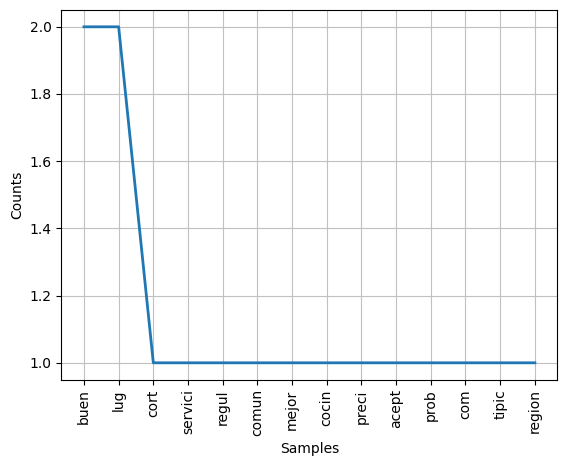

<Axes: xlabel='Samples', ylabel='Counts'>

In [16]:
fdist = FreqDist(token_df['Stemmed words'][random.randint(0, df.shape[0])])
fdist.plot(30, cumulative = False)

### Vectorización, modelado y evaluación

Como primer paso para el modelado, es necesario vectorizar las reseñas para que el computador pueda tener un correcto entendimiento de estas, por lo que un primer paso es juntar los lemas enlistados en oraciones representantes de sus respectivas reseñas. Igualmente, al juntar estas oraciones se hace la división de datos de entrenaiento y test. Los datos de entrenamiento se parten a su vez en modelado y validación.

In [17]:
token_df['Text'] = [' '.join(text) for text in token_df['Stemmed words']]

X = token_df['Text']
Y = token_df['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777)
X_modeling, X_validation, Y_modeling, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=777)

Ahora bien, para vectorizar se tendrán en cuenta 3 formas de vectorización, que, teniendo en cuenta las ventajas y desvantajas de cada una, se conoce que no hay un mejor vectorizador para todos los casos. La elección del vectorizador depende de la complejidad de las reseñas, por lo que se construye, primero, un vectorizador de forma 'word2vec' y posteriormente, se hace una funación que evalúe la calidad del resultado de modelado y validación para los vectorizadores 'word2vec', 'Count' y 'Tfidf', el cual retorna el mejor vectorizador observando los resultados obtenidos.

In [18]:
def word2vec(model):
    sentences = [text.split() for text in X_train]
    word2vec_vectorizer = Word2Vec(sentences, vector_size=3, window=2, min_count=1)
    X_list_train = []
    for text in sentences:
        vector = np.zeros(3) 
        for word in text:
            if word in word2vec_vectorizer.wv:
                vector += word2vec_vectorizer.wv[word]
        X_list_train.append(vector)
    X_temp_train = np.array(X_list_train)
    X_temp_modeling, X_temp_validation, Y_temp_modeling, Y_temp_validation = train_test_split(X_temp_train, Y_train, test_size=0.2, random_state=777)
    model.fit(X_temp_modeling, Y_temp_modeling)
    Y_temp_pred_validation = model.predict(X_temp_validation)
    score = f1_score(Y_temp_validation, Y_temp_pred_validation, average='micro')
    return word2vec_vectorizer, score, model


In [19]:
def best_vectorizer(model):
    best_vectorizer = None
    best_score = 0
    for vectorizer in ['CountVectorizer', 'TfidfVectorizer']:
        if vectorizer == 'CountVectorizer':
            vectorizer = CountVectorizer()
        else:
            vectorizer = TfidfVectorizer()
        X_modeling_transformed = vectorizer.fit_transform(X_modeling)
        model.fit(X_modeling_transformed, Y_modeling)
        X_validation_transformed = vectorizer.transform(X_validation)
        Y_pred_validation = model.predict(X_validation_transformed)
        score = f1_score(Y_validation, Y_pred_validation, average='micro')
        if score > best_score:
            best_score = score
            best_vectorizer = vectorizer
    try:
        word2vec_vectorizer, word2vec_score, word2vec_model = word2vec(model)
        if word2vec_score > best_score:
            best_score = word2vec_score
            best_vectorizer = word2vec_vectorizer
            model = word2vec_model
    except:
        print("(!) No se pudo realizar word2vec por el motivo mostrado")
    print(f">> El mejor vectorizador es {best_vectorizer} con un score f1 de {best_score}")
    return best_vectorizer, model

Ahora, se procede a hacer el modelado por medio de tres algoritmos para observar la mejor alternativa.

#### Modelado con 'Clasificador Red Neuronal' (Camilo Mercado)

Como primer algoritmo se usa una red neuronal para el análisis de texto. Las redes neuronales son modelos de aprendizaje automático que pueden aprender patrones y características complejas en los datos, incluyendo el texto en las reseñas para análisis de sentimientos. Al entrenar una red neuronal con datos de texto etiquetados, puede aprender a reconocer patrones y realizar predicciones precisas en nuevos textos lo cual es el objetivo en este contexto.

Se presenta el procedimiento de modelamiento, primero se hace la búsqueda de los mejores hiperparámetros para la red neuronal por medio de GridSearch, pero, por su tiempo de procesamiento no se ejecuta el código, se presenta comentado pero se presenta el mejor modelo hallado por GridSearch con validación cruzada.

In [20]:
# particiones = KFold(n_splits=75, shuffle=True, random_state=777)
# param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],'solver':['lbfgs', 'sgd', 'adam'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}
# algorithm = MLPClassifier( alpha=1e-5, random_state=777)
# model = GridSearchCV(algorithm, param_grid, cv=particiones, scoring='f1_micro')
# vectorizer, model = best_vectorizer(model)
# model.best_params_

La mejor red neuronal hallada tiene una forma de activación logistic, un solver lbfgs y un rango de aprendizaje adaptativo. En este caso, la función de activación determina la salida de una neurona dada una entrada o conjunto de entradas. La "logistic" es también conocida como función sigmoide. Transforma los valores de entrada a una escala de 0 a 1. El solver es el algoritmo utilizado para entrenar la red neuronal, es decir, para optimizar los pesos de la red. "lbfgs" es un optimizador en el espacio de los parámetros. El rango de aprendizaje (o tasa de aprendizaje) es un parámetro que determina cuánto se ajustan los pesos de la red en cada paso del entrenamiento. Un rango de aprendizaje adaptativo significa que este valor se ajusta a lo largo del entrenamiento. Por lo general, se inicia con un valor más alto para hacer grandes ajustes al principio, y luego se reduce para hacer ajustes más pequeños y precisos a medida que el modelo se acerca a la solución óptima. Este se presenta a continuación:

In [21]:
model = MLPClassifier( alpha=1e-5, random_state=777, activation='logistic', solver='lbfgs', learning_rate='adaptive', max_iter=1000)
vectorizer, model = best_vectorizer(model)

>> El mejor vectorizador es TfidfVectorizer() con un score f1 de 0.44841269841269843


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Teniendo esto en cuenta, y que si falla el modelo de vectorización word2vec añade latencia al resultado, este se descarta, se genera el error y se continua con los resultados de los otros dos modelos de vectorización.
Ahora, habiendo hallado el mejor modelo y vectorizador posibles para esta configuración de una red neuronal, se realiza el entrenamiento con el set completo de entrenamiento:

In [22]:
X_train_transformed = vectorizer.fit_transform(X_train)
model.fit(X_train_transformed, Y_train)
X_test_transformed = vectorizer.transform(X_test)
Y_pred_test = model.predict(X_test_transformed)
score = f1_score(Y_test, Y_pred_test, average='micro')
print(f">> El puntaje f1 de test es {score}")

>> El puntaje f1 de test es 0.4641269841269841


Teniendo el modelo entrenado y contando con un score f1 de 0,46, se procede a validar a daetalle el resultado, que, obtenido por medio de GridSearchCV supone ser el mejor posible para obtener el resultado más alto para la métrica f1.

#### Validación cuantitativa con 'Clasificador Red Neuronal' (Camilo Mercado)

Recall: 0.4641269841269841
Precisión: 0.4641269841269841
Puntuación F1: 0.4641269841269841


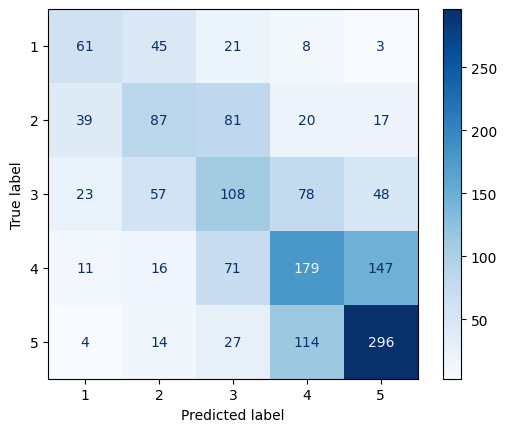

In [23]:
print("Recall: {}".format(recall_score(Y_test, Y_pred_test, average='micro')))
print("Precisión: {}".format(precision_score(Y_test, Y_pred_test, average='micro')))
print("Puntuación F1: {}".format(f1_score(Y_test, Y_pred_test, average='micro')))

cm = confusion_matrix(Y_test, Y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

Se observa como el modelo construido acierta el 46,4% de las veces en etiquetar un comentario en una clase definida correctamente. Igualmente, un 46,4% de veces (también) los datos de una clase efectivamente se clasifican como datos de esta, lo cuál es un buen indicador de la forma en cómo clasifica las reseñas. Igualmente, se debe mencionar que la mayoría de comentarios se concentran al rededor de la clase correcta, por ejemplo, en el caso de la clase 5 (comentarios muy positivos) la mayoría de comentarios se encuentran clasificados entre las clases 4 o 5, lo cuál denota que, aunque o se clasifican como clase 5, se sigue notando la clasificación positiva de los comentarios otorgándoles una clase 4, que significa positivo. por otra parte, se observan que los comentarios muy negativos (Clase 1) se clasifican la mayoría entre clases 1 y 2, algunos en la clase 3, siendo el mayor volumen en la clase, pero se le da una buena notacióin, ya que los comentarios negativos los clasifica efectivamente como comentarios negativos, pero con diferente fuerza, la cual puede llegar a ser subjetiva.

Igualmente, se observa que muy pocos comentarios son clasificados completamente de forma errónea, por ejemplo, los 3 comentarios clasificados como clase 5 (muy positivos) que en verdad eran clase 1 (muy negativos), los cuales se procede a analizar con mayor detaolle a continuación.

A modo de ejemplo se selecciona un comentario clasificado con clase 5 siendo en verdad de clase 1:

In [24]:
falsos_negativos = (Y_test == 1) & (Y_pred_test == 5)

muestra_falso_negativo = X_test[falsos_negativos].sample(1).values[0]
fila_coincidente = token_df.loc[token_df['Text'] == muestra_falso_negativo]
resenia_falso_negativo = fila_coincidente['Review'].values[0]
print(resenia_falso_negativo)

Si no alquilar una bicicleta, va a parecer bastante tonto caminando todo 100 calles idénticas mirando absolutamente nada cuando se compara este lugar con el resto de la hermosa Colombia. De hecho, salir de la ciudad y diríjase hacia Santa Marta, Cartagena es una trampa para turistas.


Es posible ver que este comentario realmente tiene significado positivo pero su clase original es negativa. esto puede ser ocasionado por una mala clasificación de los datos o un error en el proceso de etiquetado en el set de datos como errores humanos al colocar la calificación erronea y enviar el comentario. En este caso, es positivo que el algoritmo clasifique este tipo de comentarios erroneamente para hacer la correccón de la clase a la que debería pertenecer, notando que el algoritmo muestra un buen grado de validez.

De la misma forma se busca observar una reseña de clase 5 (muy positiva) que fue clasificada como clase 1 (muy negativa) de las 4 reseñas etiquetadas de forma completamente erronea:

In [25]:
falsos_positivos = (Y_test == 5) & (Y_pred_test == 1)

muestra_falso_positivo = X_test[falsos_positivos].sample(1).values[0]
fila_coincidente = token_df.loc[token_df['Text'] == muestra_falso_positivo]
resenia_falso_positivo = fila_coincidente['Review'].values[0]
print(resenia_falso_positivo)

es un lugar imponente, bello y cargado de historia. Recomiendo alquilar la audioguía por 10.000 pesos colombianos ya que ayudará a entender y aprender sobre lo sucedido en el castillo. La entrada cuesta unos 17.000 pesos y los vale. De mañana /siesta el sol pega a pleno, ir protegido y llevar agua!. Abre hasta las 18hs. A 1 cuadra de allí están los zapatos viejos para sacrse una linda foto.


En este caso se puede observar la connotación positiva del comentario, aun así, frases como 'cobran al doble' o 'precio y desayuno adicional' son negativas. Esto puede hacer que el clasificador pueda tomar las palabras como negativas y otorgarles una calificación equivocada, lo cual se recomienda, en caso de uso del algoritmo que sea revisado por un factor humano que supervise la clasificación de la máquina.

Ahora se analizan los valores de métrica para cada una de las clases habiendo visto ejempos de casos de fallo.

In [26]:
report = classification_report(Y_test, Y_pred_test)
print(report)

              precision    recall  f1-score   support

           1       0.44      0.44      0.44       138
           2       0.40      0.36      0.38       244
           3       0.35      0.34      0.35       314
           4       0.45      0.42      0.43       424
           5       0.58      0.65      0.61       455

    accuracy                           0.46      1575
   macro avg       0.44      0.44      0.44      1575
weighted avg       0.46      0.46      0.46      1575



Para este contexto, se le da mayor valor al recall que la precisión, pues, como se discutió, existen casos en donde una clase cercana es una clasificación aproximadamente correcta pero *precisa*, por lo que se interpreta principalmente este valor para cada una de las clases.

Se observa que los valores más altos están en clases donde el significado de sus reseñas son extremos (clase 1 y 5), donde incluso en la clase 5 más de la mitad de los datos de la clase tienen una clasificación correcta. Igualmente se observa que a pesar que estén los resultados por debajo de la mitad del porcentaje de recall, un detalle a tener en cuenta son los datos de clases cercanas, que, si bien no se le está etiquetando en su clase correspondiente, se le está dando una notación positiva o negativa similar a la clase verdadera, haciendo un trabajo correcto.

En este contexto, se puede observar que la clase con las menores métricas de presición y recall (por lo tanto f1 también) es la clase 3, que, al ser neutra, es fácil de mal clasificar, sin emargo, eln la matriz de confusión, se obserav como la mayoría de los valores de concentran en la clase correcta y se dispersan a medida que la clase deja de corresponder. A pesar de tener el mayor número de valores mal clasificados respecto a las otras clases, se justifica al tener en cuenta que los comentarios neutros carecen de sesgo para clasificarlos de una manera correcta, como se muestra en el siguiente ejemplo:

In [27]:
falsos_neg_3s = (Y_test == 3) & (Y_pred_test == 1)
falsos_pos_3s = (Y_test == 3) & (Y_pred_test == 5)

muestra_falso_neg_3 = X_test[falsos_neg_3s].sample(2).values[0]
muestra_falso_pos_3 = X_test[falsos_pos_3s].sample(1).values[0]
fila_coincidente_neg = token_df.loc[token_df['Text'] == muestra_falso_neg_3]
fila_coincidente_pos = token_df.loc[token_df['Text'] == muestra_falso_pos_3]
resenia_falso_neg_3 = fila_coincidente_neg['Review'].values[0]
resenia_falso_pos_3 = fila_coincidente_pos['Review'].values[0]
print(">> Clase 1 siendo 3:",resenia_falso_neg_3)
print(">> Clase 5 siendo 3:",resenia_falso_pos_3)

>> Clase 1 siendo 3: En general el hotel tiene lo basico para cumplir las necesidades de un viaje de corta estancia. El servicio del personal es algo que se puede destacar. Realicé mi reservación por Booking.com, al llegar al hotel no la tenian registrada. El personal de front desk realizó el registro y me respetó la tarifa.  Los muebles de la habitación estan descuidados y desgastados, la silla de oficina no servia ya que no se podia elevar, la velocidad del internet era pésima y el aire acondicionado super ruidoso. Los puntos buenos es que es un hotel muy silencioso, si se mantiene apagado el aire acondicionado,en general es limpio el hotel y se puede descansar bien. El desayuno es muy básico y no existe restaurante en el hotel para realizar otros alimentos. A un lado hay una pequeña plaza_x0085_
>> Clase 5 siendo 3: Es un monumento que merece la pena conocer si se va a La Habana. Nosotros los pudimos ver al anochecer con un aro iris detrás y era muy espectacular.


Se observa que los comentarios neutros clasificados como muy malos cuentan con connotación negativa, usando frases como 'son un frade', 'engañan a la gente', 'no paga', lo que es facil de clasificar como algo negativo, pero la puntuación otorgada es clase 3, aun así se considera que el clasificador funciona de manera correcta.

Por la otra parte, los comentarios neutros clasificados como muy buenos cuentan con palabras positivas como 'muy bonita' pero al ser neutro es dificil de clasificar con qué contexto se dice muy bonita, por lo que este tipo de casos se recomiendan para reafirmaión por parte humana por el hecho de que este tipo de comentarios dependen de su contexto y significado y no solo del uso de vocabulario empleado en estos.

Se procede a observar un comentario neutro clasificado como neutro:

In [28]:
verdaderos_positivos = (Y_test == 3) & (Y_pred_test == 3)

muestra_verdadero_positivo = X_test[verdaderos_positivos].sample(1).values[0]
fila_coincidente = token_df.loc[token_df['Text'] == muestra_verdadero_positivo]
resenia_verdadero_positivo = fila_coincidente['Review'].values[0]
print(resenia_verdadero_positivo)

He estado en Chichen Itza muchas veces en los últimos años y cada año estoy más decepcionado. Las ruinas en sí son impresionantes, aunque ya no puedes subir algo. Eso en sí mismo y por sí mismo está bien porque la necesidad de proteger las ruinas de vandalismo es real. he visto Maria ama Otto esculpidos en la pared de el centro comercial y me sentí desconsolada la primera vez que subimos. Los caminos para pasear por las ruinas están bien cuidadas - alguien con problemas de rodillas podría fácilmente moverse. Pero por cada camino, alguien está tratando de vender algo y no sólo de una mesa de mercancías. se acercan, mintiendo sosteniendo una muy bella pieza diciendo "sólo 5 dólares" y cuando se mira de cerca, dicen que - ah, no para esta pieza, es 1300 pesos. Para mí, es ofensivo y ruinas el espíritu de una de las grandes ruinas de todo el tiempo. Si entras en la parte vieja de de Chichen Itza, casi se puede escapar, sin embargo el vendedor aleatorio le siguen y no dejan solo. llegar tem

Se observa que en este tipo de comentarios existen oraciones como 'muy bueno' y 'mala experiencia' lo que indica que al haber cosas positivas y negativas se puede estar tratando de un comentario neutro, pero se está detectando este comportamiento de forma correcta.

Ahora, se puede observar los lemas más repetidos por cada clase predecida con el set de test:

In [29]:
most_common_words = {}

for class_label in set(Y_pred_test):
    filtered_text = X_test[Y_pred_test == class_label]
    concatenated_text = ' '.join(filtered_text)
    words = nltk.word_tokenize(concatenated_text)
    fdist = FreqDist(words)
    sorted_words = sorted(fdist.items(), key=lambda x: x[1], reverse=True)
    
    most_common_words[class_label] = sorted_words[0][0] + ", " + sorted_words[1][0] + ", " + sorted_words[2][0] + ", " + sorted_words[3][0] + ", " + sorted_words[5][0]

for class_label, word in most_common_words.items():
    print(f"Clase {class_label}: Palabras más repetidas: {word}")
    


Clase 1: Palabras más repetidas: hotel, habit, lleg, servici, mal
Clase 2: Palabras más repetidas: hotel, habit, com, lug, servici
Clase 3: Palabras más repetidas: buen, hotel, habit, si, bien
Clase 4: Palabras más repetidas: buen, hotel, lug, com, habit
Clase 5: Palabras más repetidas: buen, com, lug, excelent, hotel


Se observan que las palabras con 'excelent' entran en la clase 5, 'buen' entre 5, 4 y 3, 'mal' entre la clase 2. Igualmente se observan palabras repetidas en todas las clases por lo que se sabe que no aportan al análisis y el algoritmo no  tiene en cuenta estas como principales criterios de clasificación , pues, pueden ser usadas en cualquier contexto, por ejemplo el lema 'hotel'.

Teniendo esto en cuenta, se guarda el modelo en una variable por si se desea utilizar posteriormente.

In [30]:
MLP_model = model
MLP_vectorizer = vectorizer

#### Modelado con 'SVC' (David Leon)

In [31]:
model = SVC()

vectorizer, model = best_vectorizer(model)

#### Validación cuantitativa con 'SVC' (David Leon)

#### Modelado con 'Naive-Bayes multinomial' (Natalia Ortega)

In [ ]:
model = MultinomialNB()

vectorizer, model = best_vectorizer(model)

(!) No se pudo realizar word2vec por el motivo mostrado
>> El mejor vectorizador es CountVectorizer() con un score f1 de 0.44761904761904764


#### Validación cuantitativa con 'Naive-Bayes multinomial' (Natalia Ortega)

## Resultados

In [ ]:
model = MLP_model
vectorizer = MLP_vectorizer

### Etiquetado de los datos propocionados

Para realizar el etiquetado de los datos con el modelo construido y el vectorizador usado, primero se lee el archivo de datos sin etiquetar.

In [ ]:
df_etiquetado = pd.read_csv('./data/particion_prueba_estudiantes.csv', sep=',', encoding = 'utf-8')

Para facilidad y legibilidad se hace una función capaz de vectorizar, dar un resultado en formato para predecir y limpiar aquellas columnas que originalmente no se encontraban en el formato de los dadtos proporcionados.

In [ ]:
def clean_vectorize(data: pd.DataFrame, vectorizer):
    data['Text'] = [' '.join(text) for text in data['Stemmed words']]
    X_etiquetado = vectorizer.transform(data['Text'])
    data.drop(['Text', 'Words', 'Stemmed words'], axis=1, inplace=True)
    return X_etiquetado

Se hacen los pasos de tokenización, limpieza de datos y la transformacón en vectores para poder predecir la clase de cada una de las reseñas dadas.

In [ ]:
tokenize(df_etiquetado)
clean_process(df_etiquetado)
X_etiquetado = clean_vectorize(df_etiquetado, vectorizer)

Se hace la predicción de las clases a las que pertenecen los comentarios, la cual se ve de la siguiente forma:

In [ ]:
df_etiquetado['Class'] = model.predict(X_etiquetado)
df_etiquetado.head()

,Review,Class
0,"La primera noche nos encontramos en la habitación con un nido (5) de cucarachas muertas y la alfombra muy sucia...que por cierto nunca limpiaron hasta que reclamamos. La cena de fin de año fue un bufete que acabó en un tremendo desorden por el excesivo número de mesas vendidas, no se podía caminar para ir a servirte la comida, para luego encontrarte con bandejas vacías, mi esposa y yo y otra pareja ""NO CENAMOS"" porque nos encontramos con puras bandejas vacías!!...pagamos $2800 pesos por por pareja por nada!!! El servicio del restaurante pesimo, pesimo,pesimo....se tardaron muchísimo tiempo en atendernos, nos trajeron el desayuno en partes, nunca nos dieron el café que pedimos desde que llegamos....un pésimo servicio El frigobar vacío y después de reclamar lo surtieron pero_x0085_",1
1,"A una calle de catedral con platillos tradicionales, tipo Gourmet, de buen sabor y calidad.\nSi bien ofrecen una carta con los platillos más representativos de cada temporada como mole de caderas, poblano, chinicuiles, chiles en nogada, escamoles y cemitas; son principalmente para degustación, no...Más",4
2,Porciones muy miserables\nAgua con sabor a cloro \nMuy distraídos los meseros \nNo llena las expectativas\nHay mejores opciones,1
3,"Cartagena encanta. De todas las ciudades coloniales que hemos visitado es la más linda y mejor conservada. Recomiendo recorrerla tanto de día como de noche ya que son visiones distintas que vale la pena vivir. Llena de vida, tiendas, restaurantes, colorida, vibrante, calles y rincones que en cada momento guardan una sorpresa. Mi calificación habría sido excelente sino fuera por algunos detalles que deberían mejorar. Lamentablemente falta preocupación por la limpieza de las calles (problema que se repite en el resto de la ciudad) y un mejoramiento en los alcantarillados de las aguas servidas. Además por la estrechez de las calles deberían habilitar vías exclusivas para peatones.",5
4,"Ibamos con mucha ilusion de disfrutar el espectaculo de luz y sonido pero la verdad nos decepcionó,te ubican en una esquina a la entrada de las ruinas,y no al centro por lo que no puedes apreciar casi nada,las personas se paran a tomar fotografias debido a que no se alcanza a ver nada si estas sentado,al inicio y al final del espectaculo no dejan prendidas las luces para que puedas tomar fotografias, al contrario queda todo en obscuridad y las personas de la tercera edad tiene problemas para salir pues no iluminan ni el camino para salida, deberian poner aunque sea unas antorchas para iluminar,la verdad no lo recomiendo es una pena que una maravilla como lo es chichen itza tenga un espectaculo tan carente .",3


Igualmente se observa un ejemplo de comentario por cada una de las clases para validar el significado de estas y observar si el clasificador lo está haciendo de forma correcta.

In [ ]:
clases_muestra = df_etiquetado['Class'].unique()
comentarios_muestra = []
for clase in clases_muestra:
    comentario = df_etiquetado[df_etiquetado['Class'] == clase]['Review'].iloc[1]
    comentarios_muestra.append(comentario)
tabla_muestra = pd.DataFrame({'Clase': clases_muestra, 'Comentario': comentarios_muestra})
tabla_muestra.sort_values('Clase', inplace=True)

tabla_muestra

,Clase,Comentario
0,1,Porciones muy miserables\nAgua con sabor a cloro \nMuy distraídos los meseros \nNo llena las expectativas\nHay mejores opciones
4,2,"Todos los días que estuve tuve que bajar 2 y hasta tres veces porque no funcionan las llaves para abrir la habitación. Además, había varios huéspedes sin cubrebocas y no respetan el número de personas en el elevador. No volveremos a este hotel."
3,3,"Excelente hotel, Muchas atracciones a su alrededor, habitaciones muy comodas y limpias, En el lobby del hotel siempre hay Cafe o algun tipo de jugo para los huespedes, el personal es de lo mejor, todos muy amables, cuando regrese a merida siempre sera mi casa. todo el personal, desde la chica que limpia hasta el manager del hotel siempre estan dispuestos a ayudar a los huespedes. Mil gracias por todas las atenciones. Siempre recomendare este hotel John Velez"
1,4,"bueno, barato, no es de lujo, perfecta ubicación para la vieja Habana y vistas increíbles. No esperes lujo, pero es un buen lugar para dormir, un buen desayuno y una impresionante vista del Malecón. estarás bien en un lugar que es como la Habana: no es nuevo, no son perfectas pero agradable. Me alojaría aquí de nuevo."
2,5,"Buscando un restaurante para sentarse, nos encontramos con el recepcionista del lugar que nos convenció que se liberaría una mesa en la terraza y que el lugar era una casa de familia que hacia comida. La mesa no se libero. Cuando nos trajeron la carta...Más"


### Exportación a la carpeta 'result'

Por último, se guarda el resultado de las reseñas eqtiquetadas en la carpeta 'result' para su revisión.

In [ ]:
df_etiquetado.to_csv('./result/particion_etiquetado.csv', sep=';', index=False)